필요한 라이브러리 임포트

In [ ]:
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

1. 데이터 로드 및 전처리
torchvision.transforms 모듈을 활용하여 이미지 크기 조정 및 데이터 증강 수행
- train data에 색조 변화, 회전을 적용하여 모델의 일반화 성능을 향상
- 모든 데이터에 정규화 적용


In [ ]:
batch_size = 16
img_height = 224
img_width = 224

# transforms 모듈로 이미지 전처리 과정 구성
train_transforms = transforms.Compose([
    transforms.Resize((img_height,img_width)),
    transforms.ColorJitter(brightness=0.2),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # RGB 컬러
])

val_transforms = transforms.Compose([
    transforms.Resize((img_height,img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


PyTorch의 Dataset 클래스를 상속하여 두피 이미지 데이터 불러옴
- 데이터셋 디렉토리에서 이미지를 불러와 클래스 별로 라벨링
- ___getitem___()에서 폴더명으로 라벨을 지정하여 반환

torch.Size([16, 3, 224, 224])


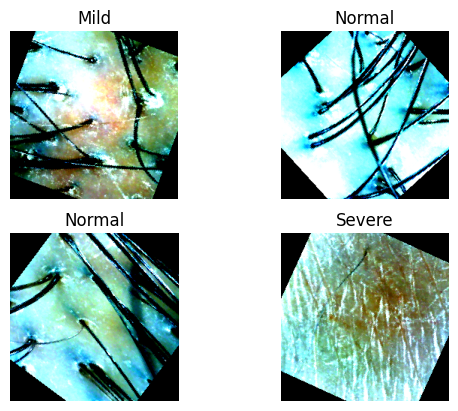

In [ ]:
class CustomImageDataset(Dataset):
    # 기본 정보 초기화
    def __init__(self, img_dir, transform=None):
        self.transform = transform
        root = Path(img_dir)
        self.paths = list(root.glob('*/*'))
        self.class_name = ['Normal', 'Mild', 'Moderate', 'Severe']
        self.cindex = {'Normal':0,'Mild':1, 'Moderate':2, 'Severe':3}

    # 데이터의 총 개수가 리턴
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = path.parts[-2]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.cindex[label] # 라벨 인코딩


train_set = CustomImageDataset('/content/hairloss2/hairloss/Training',
                                 transform = train_transforms)

val_set = CustomImageDataset('/content/hairloss2/hairloss/Validation',
                               transform = val_transforms)

class_names = train_set.class_name

train_loader = DataLoader(train_set,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(val_set,
                        batch_size=batch_size,
                        shuffle=False)

for feature, label in train_loader:
    print(feature.shape)
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(feature[i].permute((1,2,0)))
        plt.title(class_names[label[i]])
        plt.axis("off")
    break

2. MoblieNetV3-Small 모델 구축
- Inverted Residual 블록 활용 : 모델의 파라미터 수를 줄이면서 성능 유지
- Adaptive Average Pooling : 입력 크기에 상관없이 동일한 출력 제공

In [ ]:
# InvertedResidual 블록 정의
class InvertedResidual(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        self.use_res_connect = (self.stride == 1 and in_ch == out_ch)
        hidden_ch = in_ch * expand_ratio

        self.expand = nn.Conv2d(in_ch, hidden_ch, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(hidden_ch)
        self.dwconv = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=kernel_size,
                                stride=stride, padding=kernel_size // 2,
                                groups=hidden_ch, bias=False)
        self.bn2 = nn.BatchNorm2d(hidden_ch)
        self.project = nn.Conv2d(hidden_ch, out_ch, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_ch)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.expand(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.dwconv(out)
        out = self.bn2(out)
        out = self.activation(out)
        out = self.project(out)
        out = self.bn3(out)
        return x + out if self.use_res_connect else out

2.1
- 경량화 모델 적용 : MoblieNetV3-Small 기반으로 연산량 최적화

In [ ]:
class MobileNetV3Small(nn.Module):
    def __init__(self, num_classes=4, dropout=0.2):
        super(MobileNetV3Small, self).__init__()
        self.cfgs = [
            [16, 16, 3, 2, 1],
            [16, 24, 3, 2, 4],
            [24, 24, 3, 1, 3],
            [24, 40, 5, 2, 3],
            [40, 40, 5, 1, 3],
            [40, 48, 5, 1, 3],
            [48, 96, 5, 2, 6],
        ]

        self.stem_conv = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.stem_bn = nn.BatchNorm2d(16)
        self.stem_activation = nn.ReLU(inplace=True)

        layers = [InvertedResidual(in_ch, out_ch, k, s, exp) for (in_ch, out_ch, k, s, exp) in self.cfgs]
        self.blocks = nn.Sequential(*layers)

        self.last_conv = nn.Conv2d(self.cfgs[-1][1], 576, kernel_size=1, bias=False)
        self.last_bn = nn.BatchNorm2d(576)
        self.last_activation = nn.ReLU(inplace=True)

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(576, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.stem_conv(x)
        x = self.stem_bn(x)
        x = self.stem_activation(x)
        x = self.blocks(x)
        x = self.last_conv(x)
        x = self.last_bn(x)
        x = self.last_activation(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.classifier(x)
        x = self.softmax(x)
        return x

4. 학습 및 평가
- 하이퍼파라미터 설정
- Adam 옵티마이저 적용으로 학습 안정화
- CrossEntropyLoss 사용 : 다중 클래스 분류
- Epoch 150 진행

---

훈련 데이터 로드 -> 예측 -> 손실 계산 -> 역전파 -> 가중치 업데이트 반복




In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    del model
    torch.cuda.empty_cache()
except NameError:
    pass

model = MobileNetV3Small(num_classes=4, dropout=0.2).to(device)

# 옵티마이저 및 손실 함수 설정
optimizer = torch.optim.Adam(model.parameters(), lr=0.00003)
loss_fn = nn.CrossEntropyLoss()

# 학습 설정
epochs = 150
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(epochs):
    t_loss, t_acc = 0, 0
    model.train()

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (outputs.argmax(dim=1) == labels).sum() / len(labels)
        t_loss += loss.item()
        t_acc += acc

        if i % 30 == 0:
            print(f"Epoch: {epoch}, Batch: {i}, Loss: {t_loss / (i+1):.4f}, Accuracy: {t_acc/(i+1):.4f}")

    history['train_loss'].append(t_loss / len(train_loader))
    history['train_acc'].append((t_acc / len(train_loader)).cpu().numpy())

    # 평가 루프
    v_loss, v_acc = 0, 0
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            acc = (outputs.argmax(dim=1) == labels).sum() / len(labels)
            v_loss += loss.item()
            v_acc += acc

        print(f"Epoch: {epoch}, Val_Loss: {v_loss/(i+1):.4f}, Val_Accuracy: {v_acc/(i+1):.4f}")
        history['val_loss'].append(v_loss / len(val_loader))
        history['val_acc'].append((v_acc / len(val_loader)).cpu().numpy())


Epoch: 0, Batch: 0, Loss: 1.4084, Accuracy: 0.1875
Epoch: 0, Batch: 30, Loss: 1.3889, Accuracy: 0.2419
Epoch: 0, Batch: 60, Loss: 1.3875, Accuracy: 0.2428
Epoch: 0, Batch: 90, Loss: 1.3840, Accuracy: 0.2610
Epoch: 0, Batch: 120, Loss: 1.3814, Accuracy: 0.2769
Epoch: 0, Val_Loss: 1.3375, Val_Accuracy: 0.4017
Epoch: 1, Batch: 0, Loss: 1.3253, Accuracy: 0.5625
Epoch: 1, Batch: 30, Loss: 1.3628, Accuracy: 0.3528
Epoch: 1, Batch: 60, Loss: 1.3562, Accuracy: 0.3852
Epoch: 1, Batch: 90, Loss: 1.3488, Accuracy: 0.3867
Epoch: 1, Batch: 120, Loss: 1.3440, Accuracy: 0.3858
Epoch: 1, Val_Loss: 1.2917, Val_Accuracy: 0.4172
Epoch: 2, Batch: 0, Loss: 1.2742, Accuracy: 0.5000
Epoch: 2, Batch: 30, Loss: 1.3182, Accuracy: 0.3871
Epoch: 2, Batch: 60, Loss: 1.3097, Accuracy: 0.4027
Epoch: 2, Batch: 90, Loss: 1.3095, Accuracy: 0.3977
Epoch: 2, Batch: 120, Loss: 1.3021, Accuracy: 0.4050
Epoch: 2, Val_Loss: 1.2711, Val_Accuracy: 0.4354
Epoch: 3, Batch: 0, Loss: 1.3633, Accuracy: 0.2500
Epoch: 3, Batch: 30, L

5. 학습 결과 시각화
- 평가 손실 및 평가 지표에 대한 그래프를 그리고 모델의 학습 정도를 파악
- 실제 값과 예측 값을 선 그래프로 시각화 하여 직접 비교 및 관찰

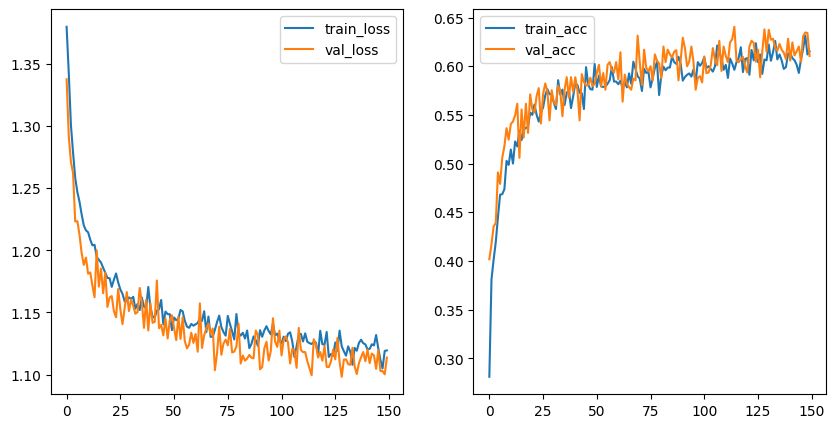

In [ ]:
loss = history['train_loss']
acc = history['train_acc']
val_loss = history['val_loss']
val_acc = history['val_acc']

eps = range(len(val_loss))

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(eps, loss, label = 'train_loss')
ax1.plot(eps, val_loss, label = 'val_loss')
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.plot(eps, acc, label = 'train_acc')
ax2.plot(eps, val_acc, label = 'val_acc')
ax2.legend()
plt.show()

6. 모델 학습 결과 분석
- 과적합 여부 : 약 100 에포크부터 훈련 데이터 및 검증 데이터 손실의 큰 차이 없음 (과적합이 심하지 않음)
- 손실값 변화 : 최종 1.1 근처로 수렴
- 정확도 변화 : 초반 학습이 진행될수록 급격히 증가 이후 완만하게 증가하며 0.6~0.63 유지 (높은 성능을 보이진 않음)
- 모델 개선 필요성 : 전반적인 정확도가 높지 않아 모델 구조 및 학습률, 에포크 변경할 필요성 보임
